# System Description
In this example, we simulate a magnetic levitation system (in 2D), as illustrated in the figure.

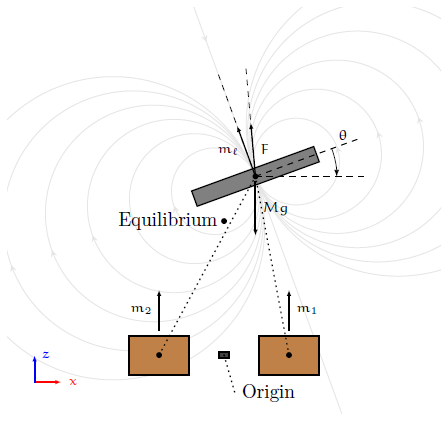

The system consists of one levitating disk magnet that is free to rotate and move in space given the force it feels from two permanent/electromagnets placed below it. Our goal is to use the sensor measurements of the magnetic field in the origin to control the current in the electromagnets so that the levitating magnet actually levitates.

Given a state vector  

$$
\zeta = [x, z, \theta, \dot{x}, \dot{z}, \dot{\theta}]^\top,
$$

where:
- $(x,z)$ is the **position** of the levitating magnet,
- $(\dot{x},\dot{z})$ is the **velocity** of the levitating magnet,
- $\theta$ is the **angle** of the magnet w.r.t. the plane (CW),
- $\dot{\theta}$ is the **angular velocity** of the magnet,  

this system can be described by the following ordinary differential equations:

$$
\begin{aligned}
\begin{bmatrix}
\ddot{x}\\
\ddot{z}
\end{bmatrix}
&= \frac{1}{M}\sum_{i=1}^{n_u} \mathbf{F}_{i} + \mathbf{g},\\
%
\ddot{\theta} &= \frac{1}{J}\sum_{i=1}^{n_u}\tau_{i},
\end{aligned}
$$

where

$$
\begin{aligned}
\mathbf{F}_{i} &= \frac{3 \mu_0}{4 \pi d_i^5}\Biggl[\left(\mathbf{m}_i \cdot \mathbf{d}_i\right) \mathbf{m}+\left(\mathbf{m} \cdot \mathbf{d}_i\right) \mathbf{m}_i+\left(\mathbf{m}_i \cdot \mathbf{m}\right) \mathbf{d}_i-\frac{5\left(\mathbf{m}_i \cdot \mathbf{d}_i\right)\left(\mathbf{m} \cdot \mathbf{d}_i\right)}{d_i^2} \mathbf{d}_i\Biggr],\\
%
\tau_{i} &= \frac{\mu_0}{4 \pi d_i^3} \left[\mathbf{m} \times\left(\frac{3\left(\mathbf{m}_i \cdot \mathbf{d}_i\right)\mathbf{d}_i}{d_i^2}-\mathbf{m}_i\right)\right].
\end{aligned}
$$

Here, we define the 2D cross product as
$$
\mathbf{a} \times \mathbf{b} := a_1 b_2 - a_2 b_1,
$$
and
$$
\mathbf{m} := m\begin{bmatrix}-\sin \theta \\ \cos \theta\end{bmatrix}, \quad \mathbf{m}_i := \begin{bmatrix}0 \\ m_i + kI_i\end{bmatrix},
$$
$$
\mathbf{d}_i := \mathbf{r} - \mathbf{r}_i, \quad d_i = \|\mathbf{d}_i\|.\quad \quad \quad
$$

Here:
- $m$ is the **magnitude of the magnetic moment** of the levitating magnet,
- $m_i$ is the **magnitude of the magnetic moment** of the supporting magnets,
- $M$ is the **mass** of the levitating magnet,
- $J$ is the **inertia** of the levitating magnet,
- $\mathbf{r}$ is the $(x,z)$ position of the levitating magnet,
- $\mathbf{r}_i$ is the $(x,z)$ position of the supporting magnets
- $g$ is the **gravitational acceleration**,
- $\mu_0$ is the **magnetic permeability of free space**
- $\mathbf{F}_i$ and $\mathbf{\tau}$ are the **force and torque** from the i'th magnet acting on the levitating magnet,
- $I_i$ is the **current** in the i'th solenoid/magnet

This system is naturally **unstable**, meaning that without control, the magnet will fall.

A magnetic sensor is also placed in the center of the based of the system, and its measurements can be modeled as
$$
    \mathbf{B}:= \frac{\mu_0}{4\pi r^3}\left[3\frac{(\mathbf{m}\cdot\mathbf{r})\mathbf{r}}{r^2}-\mathbf{m}\right].
$$

## Control Strategy
This system can be stabilized by a **Proportional-Derivative (PD) controller**.
Taking the measuremet in the x-direction, $y = B_x$, as output, and letting the currents be given by $I_1 = - I_2 = u$, where $u$ is our control input, we have a SISO system that ca be stabilized by defining

$$
u := K_p y + K_d \dot{y},
$$

where:
- $K_p$ is a **proportional gain**, which counteracts deviations from the equilibrium point, and
- $K_d$ is a **derivative gain**, which damps oscillations by reacting to the change in position.

By choosing appropriate values for $K_p$ and $K_d$, the controller ensures that the levitating magnet stays levitating.


# Simulation Example
The following is an implementation of a simulation with a PD controller for an instance of the maglev system.

### Imports & Function Definitions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Utilities
def cross2D(a, b):
    return a[0]*b[1] - a[1]*b[0]

# Magnetic field
def field(state, m, mu0):
    x, z, theta = state[0], state[1], state[2]
    r = np.array([x, z])
    r_norm = np.linalg.norm(r)
    m_vec = m*np.array([-np.sin(theta), np.cos(theta)])

    B = mu0/(4*np.pi*r_norm**3)*(3*np.dot(m_vec, r)/r_norm**2*r - m_vec)

    return B

# Sensor Measurement Function (and its derivative)
def maglev_measurements(state, m, mu0, eps=1e-6):
    """
    Compute the sensor output and its time derivative.
    The measurement is the x–component of the magnetic field.
    The derivative is approximated by finite differences with respect to [x, z, theta].
    """
    y = field(state, m, mu0)[0]

    grad = np.zeros(3)
    for i in range(3):
        state_plus = state.copy()
        state_minus = state.copy()
        state_plus[i] += eps
        state_minus[i] -= eps
        y_plus = field(state_plus, m, mu0)[0]
        y_minus = field(state_minus, m, mu0)[0]
        grad[i] = (y_plus - y_minus)/(2*eps)

    state_dot = np.array([state[3], state[4], state[5]])
    y_dot = np.dot(grad, state_dot)
    return y, y_dot

# Force & Torque
def force(m_i, m, r, mu0):
    r_norm = np.linalg.norm(r)
    term1 = np.dot(m_i, r)*m
    term2 = np.dot(m, r)*m_i
    term3 = np.dot(m_i, m)*r
    term4 = 5*np.dot(m_i, r)*np.dot(m, r)/r_norm**2*r

    F_i = (3*mu0/(4*np.pi*r_norm**5))*(term1 + term2 + term3 - term4)

    return F_i

def torque(m_i, m, r, mu0):
    r_norm = np.linalg.norm(r)
    r_hat = r/r_norm

    tau_i = (mu0/(4*np.pi*r_norm**3))*cross2D(m, 3*np.dot(m_i, r_hat)*r_hat - m_i)

    return tau_i

# Plant
def maglev_state_dynamics(state, t, u, params):
    # Unpack parameters
    M      = params["M"]
    m_val  = params["m"]
    l      = params["l"]
    g      = params["g"]
    m_sup  = params["m_support"]
    k      = params["k"]
    J      = params["J"]
    mu0    = params["mu0"]

    x, z, theta, dx, dz, dtheta = state

    # Positions of permanent magnets
    r1 = np.array([l/2, 0])
    r2 = np.array([-l/2, 0])

    # Magnetic moments of permanent magnets with control input u
    m1 = np.array([0, m_sup + k*u])
    m2 = np.array([0, m_sup - k*u])

    # Magnetic moment of levitating magnet
    m_lev = m_val*np.array([-np.sin(theta), np.cos(theta)])

    # Position of the levitating magnet
    r = np.array([x, z])

    # Compute forces from permanent magnets
    d1 = r - r1
    d2 = r - r2
    F1 = force(m1, m_lev, d1, mu0)
    F2 = force(m2, m_lev, d2, mu0)

    # Total force (including gravity acting downward)
    F_total = F1 + F2 + M*np.array([0, -g])
    ddx, ddz = F_total/M

    ddz += -5*dz # Hack to introduce damping on z

    # Compute torques from permanent magnets
    tau1 = torque(m1, m_lev, d1, mu0)
    tau2 = torque(m2, m_lev, d2, mu0)
    tau_total = tau1 + tau2
    ddtheta = tau_total/J

    return [dx, dz, dtheta, ddx, ddz, ddtheta]

# Closed-Loop Dynamics
def closed_loop_dynamics(state, t, params, Kp, Kd):
    """
    Computes the overall state derivative with a continuous-time PD controller.

    The control input is computed continuously as:
         u = -Kp * y - Kd * y_dot
    and then fed into the plant dynamics.
    """
    # Compute sensor measurement and its derivative
    y, y_dot = maglev_measurements(state, params["m"], params["mu0"])
    u = -Kp*y - Kd*y_dot

    # Compute the plant state derivative with control input u
    return maglev_state_dynamics(state, t, u, params)

# Simulation
def simulate_maglev(Kp, Kd, T, dt, state0):
    t = np.arange(0, T, dt)
    sol = odeint(closed_loop_dynamics, state0, t, args=(params, Kp, Kd))
    return t, sol

### System Simulation

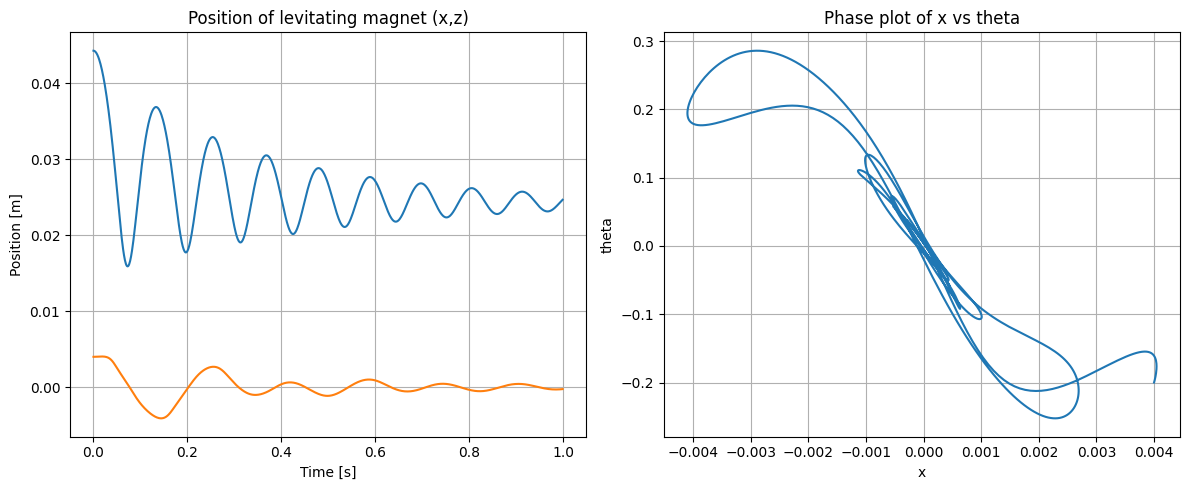

In [3]:
# Physical system parameters
params = {
    "M": 0.075,          # mass of levitating magnet (kg)
    "m": 9.375,          # magnetic moment magnitude of levitating magnet (A·m²)
    "l": 0.046,          # distance between supporting magnets (m)
    "g": 9.81,           # gravitational acceleration (m/s²)
    "m_support": 0.6250, # baseline magnetic moment of supporting magnets
    "k": 0.0377,         # scaling factor for current-to-moment conversion
    "J": 0.12e-4,        # moment of inertia (kg·m²) (simplified)
    "mu0": 4*np.pi*1e-7  # magnetic permeability of free space (H/m)
}

# Initial state: [x, z, theta, dx, dz, dtheta]
state0 = [0.004, 0.0243+0.02, -0.2, 0.0, 0.0, 0.0]

# Control parameters
Kp, Kd = 600.0, 30.0

# Simulation setup
T = 1               # Total simulation time
dt = 0.001          # Time step

# Simulation
t, sol = simulate_maglev(Kp, Kd, T, dt, state0)

# Extract control input for plotting
u_array = np.zeros(len(t))
for i, state in enumerate(sol):
    y, y_dot = maglev_measurements(state, params["m"], params["mu0"])
    u_array[i] = -Kp*y - Kd*y_dot

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, sol[:, 1])
plt.plot(t, sol[:, 0])
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Position of levitating magnet (x,z)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sol[:, 0], sol[:, 2])
plt.xlabel('x')
plt.ylabel('theta')
plt.title('Phase plot of x vs theta')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# from ipywidgets import interact, FloatSlider

# def simulate_and_plot(Kp, Kd):
#     # Run simulation
#     t, sol = simulate_maglev(Kp, Kd, T, dt, state0)

#     # Extract control input for plotting
#     u_array = np.zeros(len(t))
#     for i, state in enumerate(sol):
#         y, y_dot = maglev_measurements(state, params["m"], params["mu0"])
#         u_array[i] = -Kp*y - Kd*y_dot

#     # Plot results
#     plt.figure(figsize=(12, 5))

#     plt.subplot(1, 2, 1)
#     plt.plot(t, sol[:, 1], label='z (height)')
#     plt.plot(t, sol[:, 0], label='x (horizontal)')
#     plt.xlabel('Time [s]')
#     plt.ylabel('Position [m]')
#     plt.title('Position of levitating magnet (x, z)')
#     plt.legend()
#     plt.grid(True)

#     plt.subplot(1, 2, 2)
#     plt.plot(sol[:, 0], sol[:, 2])
#     plt.xlabel('x')
#     plt.ylabel('theta')
#     plt.title('Phase plot: x vs theta')
#     plt.grid(True)

#     plt.tight_layout()
#     plt.show()

# interact(
#     simulate_and_plot,
#     Kp=FloatSlider(value=600.0, min=0, max=1000, step=10.0, description='Kp'),
#     Kd=FloatSlider(value=30.0, min=0, max=200, step=5.0, description='Kd')
# )

from ipysim.widgets import interactive_simulation

# Optional: customize your simulation parameters
custom_params = {
    "M": 0.075,          # mass of levitating magnet (kg)
    "m": 9.375,          # magnetic moment magnitude (A·m²)
    "l": 0.046,          # magnet spacing (m)
    "g": 9.81,           # gravity (m/s²)
    "m_support": 0.6250, # baseline support dipole moment
    "k": 0.0377,         # current-to-moment scaling factor
    "J": 0.12e-4,        # moment of inertia (kg·m²)
    "mu0": 4 * np.pi * 1e-7  # vacuum permeability (H/m)
}


# Run the simulation with custom inputs
interactive_simulation(
    params=custom_params,
    state0=None,
    T=2.0,
    dt=0.001,
    Kp_default=600.0,
    Kd_default=30.0
)


interactive(children=(FloatSlider(value=600.0, description='Kp', max=1000.0, step=10.0), FloatSlider(value=30.…